## Week 2: Linear Regression - Gradient Descent

Creator: Cornelia Paulik <br>
Email: cpualik@ischool.berkeley.edu <br>

#### ``Readings``

1. Raschka & Mirjalili (RM), 3rd edition: Chapter 2 (pp. 36-52), Chapter 10 (pp. 315-345) in the print version of the book.

#### ``Learning objectives``

1. Use supervised machine learning techniques to predict continuous target variables through regression analysis.
2. Examine and differentiate between stochastic and batch gradient descent methods for linear regression.
3. Assess how AI/ML techniques can be applied to track the progression of diabetes and determine their effectiveness.

#### ``Motivation``

1. Start with simple predictive models (if realistic/possible)

2. AI/ML can help predict how diabetes is likely to progress based upon a person’s weight and lifestyle.

#### ``Data``

[Paper](https://tibshirani.su.domains/ftp/lars.pdf): Efron et al. (2004): “Least Angle Regression,” Annals of Statistics (with discussion), 407–499.

[Data description](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html): 10 baseline variables (age, sex, body mass index, average blood pressure, and six blood serum measurements) and the response of interest (a quantitative measure of disease progression one year after baseline readings) for n = 442 diabetes patients.

### Step 1: Import libraries

I am using the following package versions:
* Pandas: 2.2.2
* Numpy: 1.26.4
* Matplotlib: 3.8.4
* Seaborn: 0.13.2
* Sklearn: 1.4.2
* IPython: 8.25.0
* Mlxtend: 0.23.3

In [ ]:
# %pip install mlxtend==0.23.3
# %pip install pandas==2.2.2
# %pip install numpy==1.26.4
# %pip install matplotlib==3.8.4
# %pip install seaborn==0.13.2
# %pip install sklearn==1.4.2
# %pip install ipython==8.25.0

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os

# ML/stats
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

### Step 2: Define functions

In [2]:
def lin_regplot(X, y, y_pred):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, y_pred, color='black', lw=2)    
    return 

---
### Step 3: Read data

---

In [3]:
df = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    delimiter='\t'
)

df.head(2)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


---
### Step 4: Data preprocessing

---

``rename columns``

In [4]:
df.columns = [
    'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu', 'disease_progression']

df.head(2)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


``split data into training and test``

In [5]:
# define outcome #
##################
y = df['disease_progression'].values

# define features #
###################
X = df[['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['disease_progression', 'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']

---
### Step 5: Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

Note: I am going to perform EDA with the non-standardized feature values but when we fit the model, I will work with the standardized features. Why?

`` check if any missing values``

In [6]:
df_train.isna().sum()

disease_progression    0
age                    0
sex                    0
bmi                    0
map                    0
tc                     0
ldl                    0
hdl                    0
tch                    0
ltg                    0
glu                    0
dtype: int64

``check distributions``

using describe()

In [7]:
df_train.describe()

,disease_progression,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
count,309.000000,309.000000,309.000000,309.00000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,150.045307,48.792880,1.443366,26.20000,94.564142,188.728155,113.804207,50.846278,3.989353,4.640894,91.268608
std,78.571610,13.066109,0.497588,4.40727,13.640012,34.683409,30.850892,13.573268,1.299130,0.535240,11.543917
min,31.000000,19.000000,1.000000,18.50000,65.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,84.000000,38.000000,1.000000,23.00000,84.000000,165.000000,94.200000,41.000000,3.000000,4.276700,83.000000
50%,132.000000,51.000000,1.000000,25.60000,93.000000,187.000000,111.200000,49.000000,4.000000,4.615100,92.000000
75%,206.000000,59.000000,2.000000,28.90000,105.000000,209.000000,132.000000,59.000000,5.000000,4.997200,98.000000
max,346.000000,79.000000,2.000000,41.30000,131.000000,301.000000,242.400000,98.000000,9.090000,6.107000,124.000000


using hist()

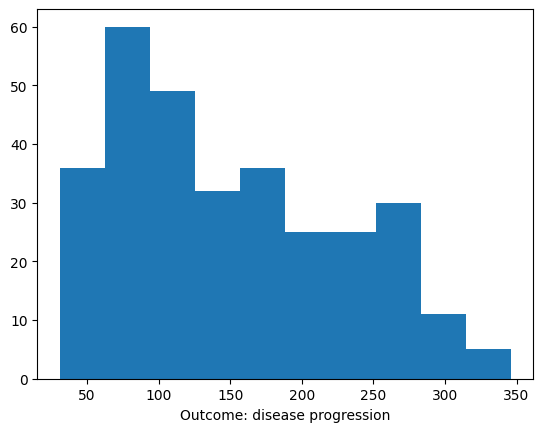

In [8]:
df_train.disease_progression.hist(grid=False)
plt.xlabel('Outcome: disease progression');

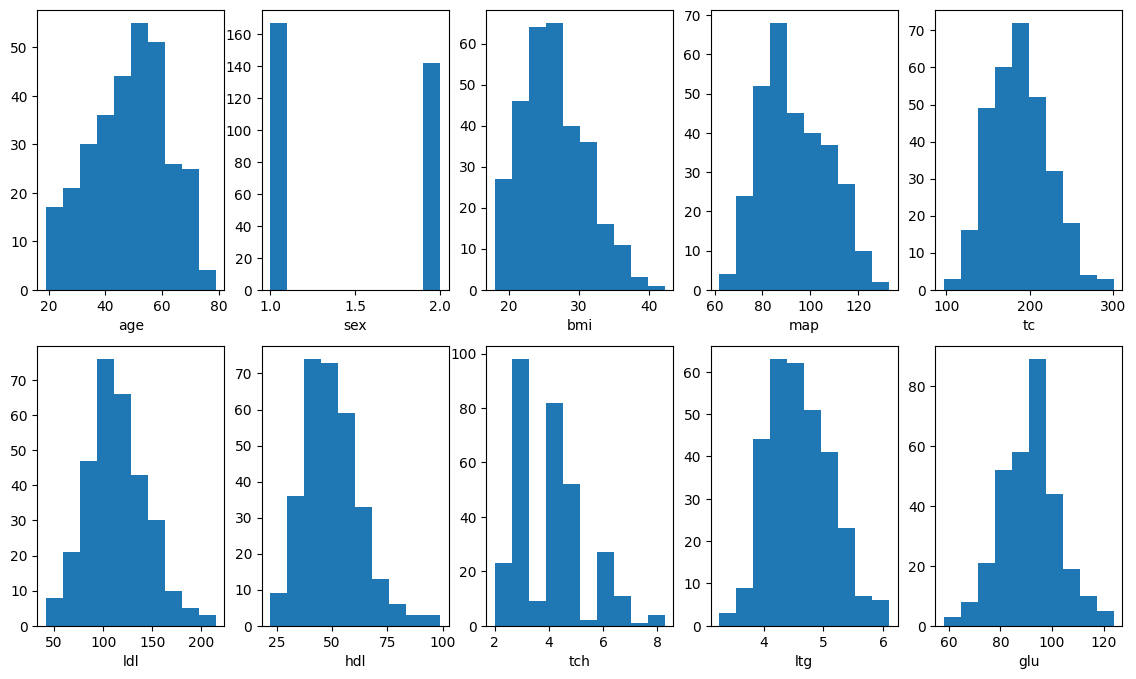

In [9]:
columns = ['age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14,8))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

``correlation matrix of outcome and feature variables``

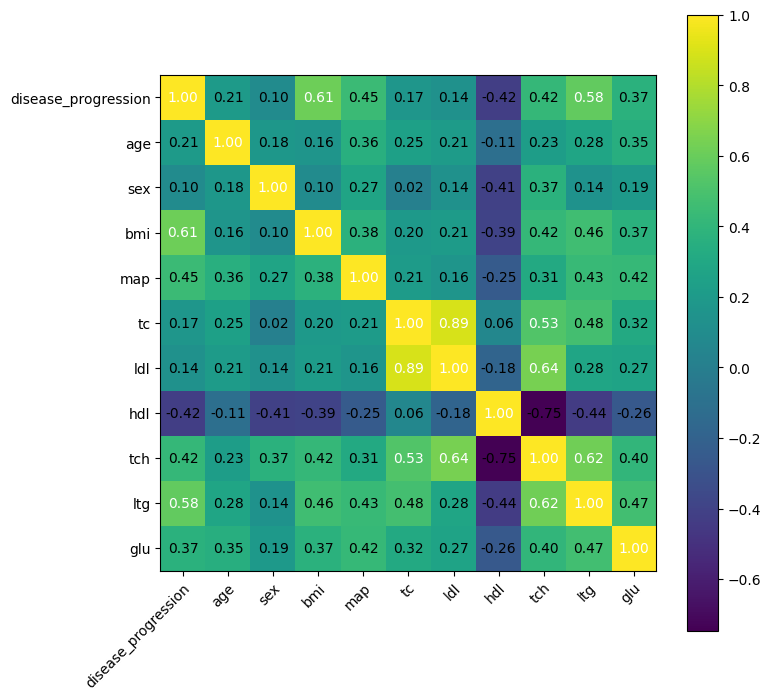

In [10]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(8, 8)
)

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict diabetes progression?

``histogram of features and outcome``

Let's focus on the outcome variable (disease_progression) and BMI for the moment.

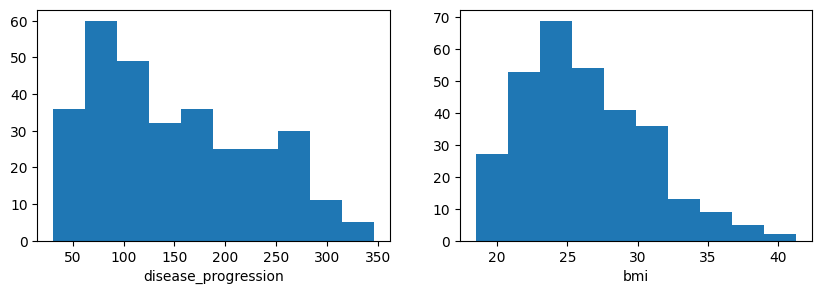

In [9]:
columns = ['disease_progression', 'bmi']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

---
### Step 6: Analysis - Linear Regression with one variable (baseline model)
---

We will begin with a single-variable linear regression to predict 'disease_progression' from 'bmi'.

The idea behind linear regression is to obtain the best-fitting straight line through the examples in the training data.

There are two ways you can fit the training data:
 - using a closed-form solution: $(X'X)^{-1}(X'y)$
 - using an iterative solution: gradient descent (stochastic, batch)

Today we will be focusing on **gradient descent** and we will implement this algorithm from scratch. 

In [11]:
# define features of interest
temp_X_train = X_train[:,2] # choose only BMI
temp_X_test = X_test[:,2] # choose only BMI

# exapand dimension so that temp_X_train is a 2D array
temp_X_train = np.expand_dims(temp_X_train, axis=1) 
temp_X_test = np.expand_dims(temp_X_test, axis=1) 

# define shape of temp_X_train
temp_shape_X_train = temp_X_train.shape[1]

``Linear Regression, w/ Gradient Descent``

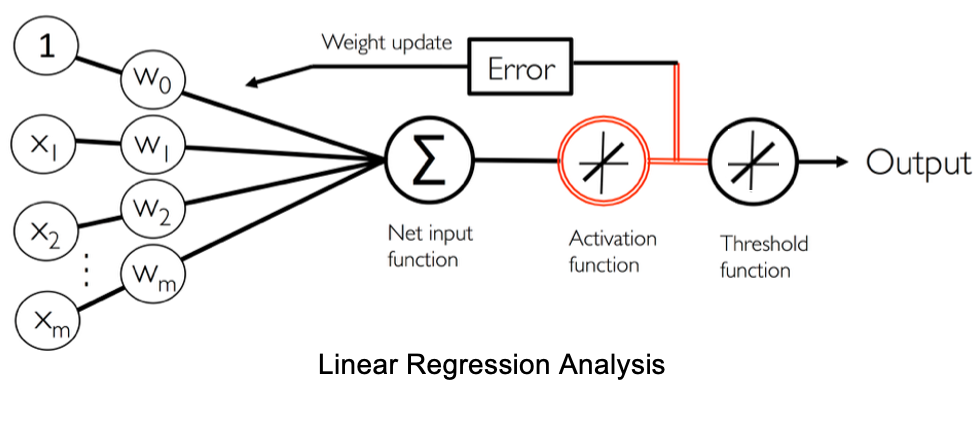

In [12]:
Image(filename='./images/linear.png', width=500)

Let j represent features, j = [1,...,m]

Let i represent observations, i = [1, ..., n]


``Net input function``:

z = $w_{0} \cdot 1 + w_{2} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$

``Linear activation function``:

$\phi(z)= w_{0} \cdot 1 + w_{2} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$


`` Compute error``:

$(y\_actual_{i} - \phi(z_{i}))$, , where $\phi(z_{i})$ is $y\_pred_{i}$

``Update weights``:

$w_{j} := w_{j} + \Delta w_{j}, \forall j \in {1,...,m}$

$\Delta w_{j} = \eta \sum _{i}(y\_actual_{i} - \phi(z_{i}))\cdot x_{i,j}, \forall j \in {1,...,m}, \forall i \in {1,...,n}$


``Threshold function``:

$\tau(z) = w_{0} \cdot 1 + w_{2} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$


`` Note on Gradient Descent``:

The weights are updated using **all training examples** (see the summation operator in the equation $\Delta w_{j}$)

In [40]:
# Step 1: initalize hyperparameters
eta = 0.02
n_iter = 100
random_state = 1

# Step 2: initalize weights (to small random numbers)
rgen = np.random.RandomState(random_state)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + temp_shape_X_train)

# Step 3: initialize cost lists
cost_ = []

# Step 4: compute net input, linear activation function, update weights, track cost
def fit(X, y):
    for iter_ in range(n_iter):
        # compute the net input function
        net_input = np.dot(X, w_[1:]) + w_[0]

        # compute the linear activation function; this gives us y_pred
        temp_y_pred = net_input
        
        # compute error
        errors = (y - temp_y_pred)
        #print(y, temp_y_pred)

        # update weights (notice how weights are updated using all training examples!)
        w_[1:] += eta * X.T.dot(errors)
        w_[0] += eta * errors.sum()

        # compute cost (we find weights by minimizing costs; in the Linear model the cost is SSE/2)
        cost = (errors**2).sum()/2.0  
        cost_.append(cost)
        
    return cost_

# Step 5: compute the threshold (linear) function
def predict(X):
    net_input = np.dot(X, w_[1:]) + w_[0]
    
    # threshold function
    y_pred = net_input
    
    return y_pred

Model fit and prediction

CPU times: user 2.65 ms, sys: 824 μs, total: 3.47 ms
Wall time: 3.09 ms


/tmp/ipykernel_1657/115608942.py:31: RuntimeWarning: overflow encountered in square
  cost = (errors**2).sum()/2.0
/srv/conda/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_1657/115608942.py:27: RuntimeWarning: invalid value encountered in add
  w_[1:] += eta * X.T.dot(errors)
/tmp/ipykernel_1657/115608942.py:28: RuntimeWarning: invalid value encountered in scalar add
  w_[0] += eta * errors.sum()


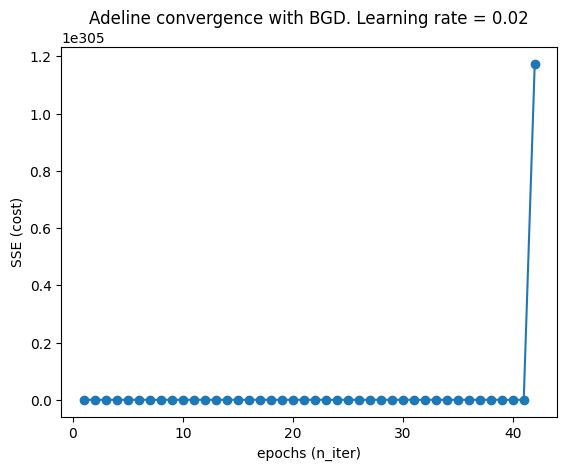

In [41]:
%time cost_ = fit(temp_X_train, y_train)
y_train_pred = predict(temp_X_train)


# plot cost
plt.plot((range(1, len(cost_) + 1)), cost_, marker='o');
plt.xlabel('epochs (n_iter)');
plt.ylabel('SSE (cost)');

plt.title('Adeline convergence with BGD. Learning rate = ' + str(eta));

Evaluation

In [24]:
print('MSE train:', mean_squared_error(y_train, y_train_pred))

y_test_pred = predict(temp_X_test)
print('MSE test:', mean_squared_error(y_test, y_test_pred))

MSE train: 6762.067470245977
MSE test: 6775.022764056133


<span style="color:chocolate"> *Exercise:*</span> 

Try increasing the number of iterations and see what happens.

Then see what happens if you change the learning rate.

If the learning rate is too large (set eta = 0.02): instead of minimizing the cost function, the error become larger after each epoch. This happens because we overshoot the global minimum.

If the learning rate is too small (set eta = 0.00000001): the cost decreases but the learning rate is so small that the algo requires lots of epochs to converge (this can be very computational expensive with large datasets!)

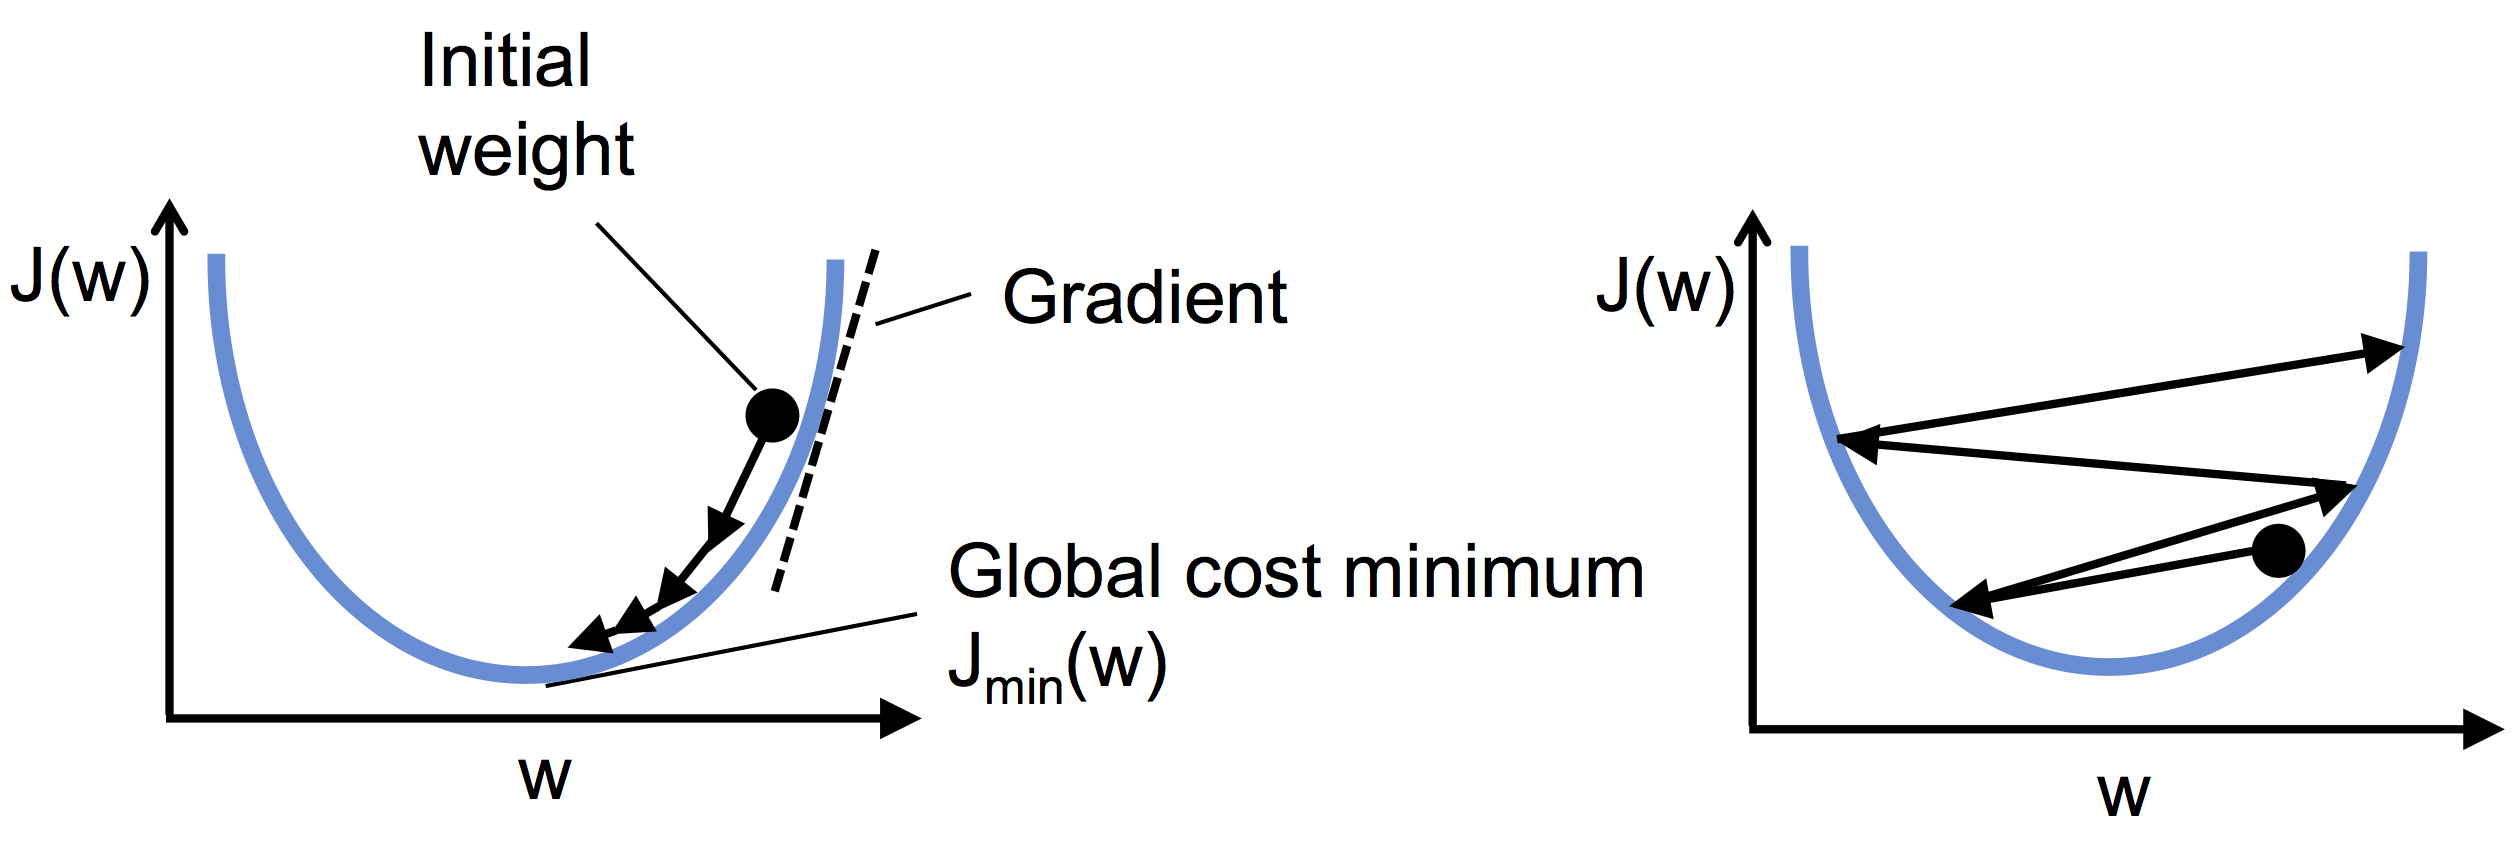

In [35]:
Image(filename='./images/effect_of_eta.png', width=500)

The left subfigure shows that if choose the "right learning rate", the cost decreases gradually, moving in the direction of the global minimum.

The right subfigure shows what happens if we choose a learning rate that is too large - we miss the global minimum.

``Linear Regression, w/ Stochastic Gradient Descent``

<span style="color:chocolate"> *Update weights:*</span>

$w_{j} := w_{j} + \Delta w_{j}, \forall j \in {1,...,m}$

$\Delta w_{j} = \eta (y\_actual_{i} - \phi(z_{i}))\cdot x_{i,j}, \forall j \in {1,...,m}, \forall i \in {1,...,n}$

`` Note on Stochastic Gradient Descent``:

The weights are updated using **one training example at a time** (no summation operator in the equation $\Delta w_{j}$)


As a result, the SGD typically reaches convergence much faster than GD because of the more frequent weight updates.

In [42]:
# Step 1: initalize hyperparameters
eta = 0.000001
n_iter = 10
random_state = 1

# Step 2: initalize weights (to small random numbers)
rgen = np.random.RandomState(random_state)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + temp_shape_X_train)

# Step 3: initialize cost lists
cost_ = []


# Step 4: compute net input, linear activation function, update weights, track cost
def fit(X, y):
    for iter_ in range(n_iter):
        cost = []
        # shuffle the data after each iteration to avoid repetitive cycles when we optimize the cost function
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        
        # [rocess one sample at a time (this is what makes it SGD)
        for idx, (xi, target) in enumerate(zip(X, y)):
            # make prediction for this single sample
            net_input = np.dot(xi, w_[1:]) + w_[0]
            prediction = net_input  # Linear activation
            
            # compute error for this sample
            error = target - prediction
            
            # update weights using this single sample
            w_[1:] += eta * error * xi
            w_[0] += eta * error
            
            # track cost for this sample
            cost.append(error**2 / 2.0)
        
        # average cost for this epoch
        avg_cost = sum(cost) / len(y)
        cost_.append(avg_cost)
    
    return cost_

# Step 5: compute the threshold (linear) function; it's just the net input function in the linear model
def predict(X):
    net_input = np.dot(X, w_[1:]) + w_[0]
    # threshold function
    y_pred = net_input
    
    return y_pred

Model fit and prediction

CPU times: user 22.2 ms, sys: 10.1 ms, total: 32.2 ms
Wall time: 25.1 ms


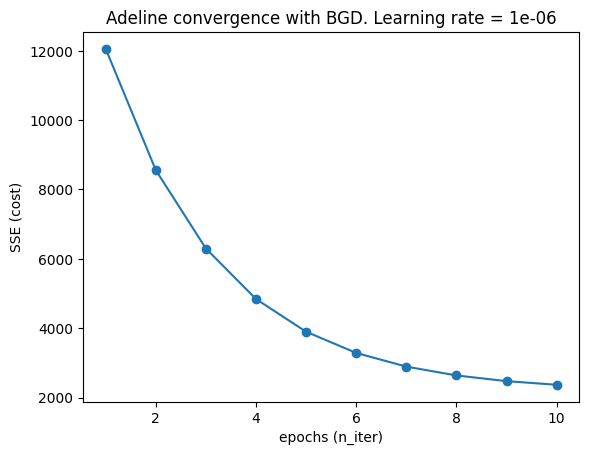

In [43]:
%time cost_ = fit(temp_X_train, y_train)
y_train_pred = predict(temp_X_train)

# plot cost
plt.plot((range(1, len(cost_) + 1)), cost_, marker='o');
plt.xlabel('epochs (n_iter)');
plt.ylabel('SSE (cost)'); # number of times y_actual != y_pred

plt.title('Adeline convergence with BGD. Learning rate = ' + str(eta));

Evaluation

In [44]:
print('MSE train:', mean_squared_error(y_train, y_train_pred))

y_test_pred = predict(temp_X_test)
print('MSE test:', mean_squared_error(y_test, y_test_pred))

MSE train: 4658.43469028781
MSE test: 4467.471009297074


``The regression line``

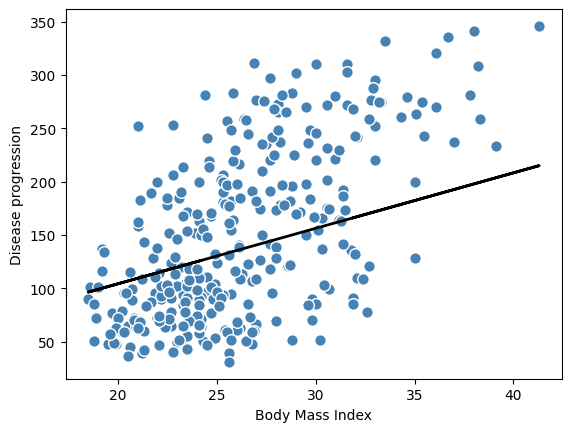

In [45]:
lin_regplot(temp_X_train, y_train, y_train_pred)
plt.xlabel('Body Mass Index')
plt.ylabel('Disease progression')
plt.show()

As you can see, the linear regression line reflects the general trend that diabetes progression tends to increase with the BMI. This observation makes sense but the data also tells us that BMI does not explain disease progression very well in many cases.

---
We just reviewed an example of an ML pipeline using a real-world scenario — predicting diabetes progression. However, this pipeline is flexible and can be modified in various stages, such as data preprocessing. What objective do you want to achieve with your first modification?

---

Here are also some example questions to explore in your breakout room:

[a] What is the Mean Squared Error (MSE) on the test data? How does it compare to the training data?

[b] How can you improve the model's MSE? Discuss your ideas, then implement one of them.

---